# Implementation of the batch-hard triplet loss in Keras

In [2]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

In [3]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, merge
from keras.layers import BatchNormalization
from keras.optimizers import *
from keras.models import Model, Sequential
from keras import objectives
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import callbacks

import numpy as np
import tensorflow as tf
import random as rand
import os
from scipy.misc import imread, imsave, imresize
from skimage import transform, filters
from skimage import color
import joblib
from scipy.spatial.distance import pdist, squareform

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Specify the dimensionality of the feature vector, the number of classes randomly sampled per batch ('p' in the paper) and the number of samples randomly selected per class per batch ('k' in the paper).

In [60]:
latent_dim = 2
num_class_per_batch = 10
num_samples_per_class = 10
batch_size = num_class_per_batch*num_samples_per_class

Here we'll load the Mnist data, preprocess, and make sampling batches easy.

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
original_img_size = (28,28,1)
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
train_by_class = []
val_by_class = []
for i in range(0,10):
    inds = (y_train == i)
    train_by_class.append(x_train[inds,:,:,:])
    inds = (y_test == i)
    val_by_class.append(x_test[inds,:,:,:])
    
def get_batch():
    batch = np.zeros((batch_size, 28,28,1))
    class_inds = rand.sample(range(0,10), num_class_per_batch)
    labels = []
    for i, cls_ind in enumerate(class_inds):
        sample_inds = rand.sample(range(0,train_by_class[cls_ind].shape[0]), num_samples_per_class)
        batch[i*num_samples_per_class:(i+1)*num_samples_per_class,:,:,:] = train_by_class[cls_ind][sample_inds,:,:,:]
        labels += num_samples_per_class * [cls_ind]
    return (batch, np.array(labels))

def get_val_batch():
    batch = np.zeros((batch_size, 28,28,1))
    class_inds = rand.sample(range(0,10), num_class_per_batch)
    labels = []
    for i, cls_ind in enumerate(class_inds):
        sample_inds = rand.sample(range(0,val_by_class[cls_ind].shape[0]), num_samples_per_class)
        batch[i*num_samples_per_class:(i+1)*num_samples_per_class,:,:,:] = val_by_class[cls_ind][sample_inds,:,:,:]
        labels += num_samples_per_class * [cls_ind]
    return (batch, np.array(labels))

def data_generator(with_labels=False):
    while True:
        batch, labels = get_batch()
        if not with_labels:
            yield (batch, np.zeros((num_class_per_batch*num_samples_per_class,)))
        else:
            yield(batch, [np.zeros((batch_size,)), to_categorical(labels, num_classes=10)])
        
def validation_generator(with_labels=False):
    while True:
        batch, labels = get_val_batch()
        if not with_labels:
            yield (batch, np.zeros((num_class_per_batch*num_samples_per_class,)))
        else:
            yield (batch, [np.zeros((batch_size,)), to_categorical(labels, num_classes=10)])



In [50]:
def get_base_net():
    net = Sequential()
    net.add(Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu', strides=(2,2), padding='same'))
    net.add(BatchNormalization())
    net.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), padding='same'))
    net.add(BatchNormalization())
    net.add(Conv2D(128, (3,3), activation='relu', strides=(2,2), padding='valid'))
    net.add(BatchNormalization())
    net.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same', name='conv4'))
    net.add(BatchNormalization())
    net.add(Flatten())
    net.add(Dense(256, activation='relu'))
    
    return net

In [51]:
def get_pairwise_dists(x, num_p=num_class_per_batch, num_k=num_samples_per_class, margin=0.5):
    # pairwise distances for whole batch
    # (redundant computation but probably still faster than alternative)
    norms = tf.reduce_sum(x*x, 1)
    norms = tf.reshape(norms, [-1, 1])
    dists = norms - 2*tf.matmul(x, x, transpose_b=True) + tf.transpose(norms)
    dists = K.sqrt(K.relu(dists))
    
    def log_sum_exp(xin, axis=1):
        e_x = tf.reduce_sum(tf.exp(xin), axis)
        log_sum = tf.log(e_x)
        return log_sum
    
    # get the max intra-class distance for each sample
    max_pos = [tf.reduce_max(tf.slice(dists, [i*num_k, i*num_k], [num_k, num_k]),axis=1) for i in range(0, num_p)]
    #max_pos = [log_sum_exp(tf.slice(dists, [i*num_k, i*num_k], [num_k, num_k]),axis=1) for i in range(0, num_p)]
    max_pos = K.concatenate(max_pos, axis=0)
    
    # get the min inter-class distance for each sample
    min_neg = []
    for i in xrange(0,num_p):
        left = tf.slice(dists, [i*num_k, 0], [num_k, i*num_k])
        right = tf.slice(dists, [i*num_k, (i+1)*num_k], [num_k, (num_p-i-1)*num_k])
        min_neg.append(tf.reduce_min(K.concatenate([left, right], axis=1), axis=1))
        #min_neg.append(log_sum_exp(margin-K.concatenate([left, right], axis=1), axis=1))
    min_neg = K.concatenate(min_neg, axis=0)
    
    min_max = K.concatenate([K.expand_dims(max_pos, axis=-1), K.expand_dims(min_neg, axis=-1)], axis=1)
    return min_max

def get_triplet_dists(x):
    x = K.transpose(x)
    max_pos = tf.gather(x, 0)
    min_neg = tf.gather(x, 1)
    L_triplet = K.expand_dims(K.relu( max_pos - min_neg ),1)
    return L_triplet
        
def pairwise_shape(inshape):
    return (inshape[0], 2)

def triplet_shape(inshape):
    return (inshape[0], 1)

def triplet_loss(zeros, dists):
    dists = batch_hard_triplets(dists)
    return K.mean(dists, axis=0)

inp = Input((28,28,1))
base_net = get_base_net()
base_out = base_net(inp)

# We branch the net into the classification branch
embeddings = Dense(latent_dim, activation=None)(base_out)
class_output = Dense(10, use_bias=True, activation='softmax')(embeddings)

# And now the triplet loss branch
pairwise_dists = Lambda(get_pairwise_dists, output_shape=pairwise_shape)(embeddings)
triplet_dists = Lambda(get_triplet_dists, output_shape=triplet_shape)(pairwise_dists)

# Output the pairwise dists for logging
triplet_net = Model(inp, outputs=[triplet_dists, pairwise_dists])
classify_net = Model(inp, class_output)


In [52]:
# This is hacky for now. The loss is the mean absolute error with zeros as the labels.
# I can use add_loss() on the triplet_dists, but I don't know if I can weight the loss
# that way for when I add cross-entropy

triplet_net.compile(loss=['mae', None], optimizer=Adam())
classify_net.compile(loss='categorical_crossentropy', optimizer='sgd')

In [59]:
# Pre-train on Classification (however many epochs you like):
classify_net.fit(x_train, to_categorical(y_train), epochs=3)

# This will output the classification net predictions on a batch of samples.
# We expect to get rows of uniform numbers, since the batch formation is in globs of classes
classify_net.predict(get_val_batch()[0], batch_size=100).argmax(axis=1).reshape([num_class_per_batch,num_samples_per_class])

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [64]:
# This I use to log the pairwise distances for positive and negative pairs over the course of training

max_pos_avg = []
min_neg_avg = []
class triplet_callback(callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        pair_dists = self.model.predict(get_val_batch()[0], batch_size=batch_size)[1].mean(axis=0)
        max_pos_avg.append(pair_dists[0])
        min_neg_avg.append(pair_dists[1])
        
# Now let's train
# Typically this won't work unless the latent dimension is at least 3.
triplet_net.fit_generator(generator=data_generator(),
    steps_per_epoch = 600,
    epochs = 5,
    validation_data=validation_generator(),
    validation_steps=20, verbose=1,
    callbacks=[triplet_callback()])

Epoch 1/5
600/600 [==============================] - 8s - loss: 0.0407 - lambda_10_loss: 0.0249 - dense_15_loss: 0.0157 - val_loss: 0.1041 - val_lambda_10_loss: 0.0687 - val_dense_15_loss: 0.0353
Epoch 2/5
600/600 [==============================] - 8s - loss: 0.0348 - lambda_10_loss: 0.0204 - dense_15_loss: 0.0143 - val_loss: 0.1464 - val_lambda_10_loss: 0.1059 - val_dense_15_loss: 0.0405
Epoch 3/5
600/600 [==============================] - 8s - loss: 0.0253 - lambda_10_loss: 0.0150 - dense_15_loss: 0.0103 - val_loss: 0.0971 - val_lambda_10_loss: 0.0637 - val_dense_15_loss: 0.0334
Epoch 4/5
600/600 [==============================] - 8s - loss: 0.0198 - lambda_10_loss: 0.0114 - dense_15_loss: 0.0084 - val_loss: 0.0927 - val_lambda_10_loss: 0.0588 - val_dense_15_loss: 0.0339
Epoch 5/5
600/600 [==============================] - 8s - loss: 0.0085 - lambda_10_loss: 0.0045 - dense_15_loss: 0.0040 - val_loss: 0.1348 - val_lambda_10_loss: 0.0989 - val_dense_15_loss: 0.0359


In [22]:
triplet_net.fit_generator(generator=data_generator(),
        steps_per_epoch = 600,
        epochs = 5,
        validation_data=validation_generator(),
        validation_steps=20, verbose=1,
        callbacks=[triplet_callback()])

Epoch 1/5
600/600 [==============================] - 8s - loss: 0.9619 - lambda_4_loss: 1.4085 - dense_8_loss: 0.7705 - val_loss: 0.7602 - val_lambda_4_loss: 1.2314 - val_dense_8_loss: 0.5582
Epoch 2/5
600/600 [==============================] - 7s - loss: 0.5812 - lambda_4_loss: 0.7626 - dense_8_loss: 0.5035 - val_loss: 0.4292 - val_lambda_4_loss: 0.5760 - val_dense_8_loss: 0.3663
Epoch 3/5
600/600 [==============================] - 7s - loss: 0.4020 - lambda_4_loss: 0.5715 - dense_8_loss: 0.3294 - val_loss: 0.3830 - val_lambda_4_loss: 0.6219 - val_dense_8_loss: 0.2806
Epoch 4/5
600/600 [==============================] - 7s - loss: 0.3188 - lambda_4_loss: 0.5045 - dense_8_loss: 0.2392 - val_loss: 0.2843 - val_lambda_4_loss: 0.4680 - val_dense_8_loss: 0.2056
Epoch 5/5
600/600 [==============================] - 7s - loss: 0.2354 - lambda_4_loss: 0.3716 - dense_8_loss: 0.1771 - val_loss: 0.3662 - val_lambda_4_loss: 0.8115 - val_dense_8_loss: 0.1754


Let's see how the pairwise distances seperated over the course of training...

<IPython.core.display.Javascript object>


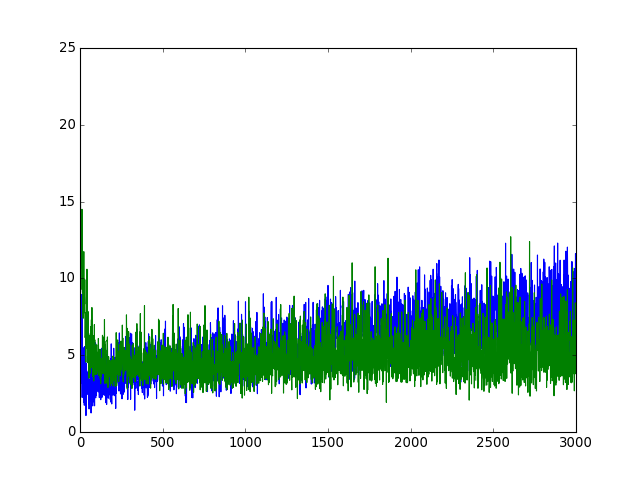

In [31]:
# One line will plot the max positive pair distance (in a batch) at each iteration
# Another line will plot the min negative pair distance (in a batch) at each iteration
plt.figure()
plt.plot(np.array(min_neg_avg[:]))
plt.plot(np.array(max_pos_avg[:]))

In [26]:
# Let's call the base_net + embedding_layer the "encoder".
encoder = Model(inp, embeddings)

# Then we pass all the test set through the encoder, organized by class
embs_by_class = []
for val in val_by_class:
    embs_by_class.append(encoder.predict(val, batch_size=batch_size))
embs_by_class[0].shape

(980, 2)

<IPython.core.display.Javascript object>


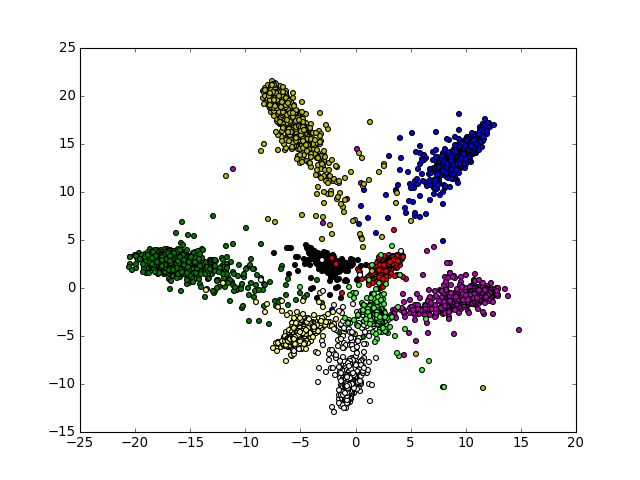

[ 1.71505916  1.64653969]
[ 2.57359338  1.16414273]
[ 0.80018163  0.71767938]
[ 2.21842837  1.29867232]
[ 0.62254763  0.53888053]
[ 1.93311739  3.27651072]
[ 1.01568592  0.75219369]
[ 0.6348511   1.80123866]
[ 0.55913717  0.75106204]


In [32]:
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'y', [1., 1., 0.5], 'w', [0.25, 1.0, 0.25]]
plt.figure()
for i, embs in enumerate(embs_by_class):
    if i == 1:
        continue
    print embs.std(axis=0)
    #embs = embs / np.expand_dims(np.linalg.norm(embs,axis=1),-1)
    plt.scatter(embs[:,0], embs[:,1], c=colors[i])

Let's do the distance histograms...

In [28]:
def get_random_neg_pairs(embs_by_class, num_pairs):
    dists = np.zeros((num_pairs,))
    for i in range(0,num_pairs):
        class_ind_1 = np.random.randint(0,10)
        class_ind_2 = rand.sample(range(0,class_ind_1)+range(class_ind_1+1,10), 1)[0]
        sample1 = np.random.randint(0,embs_by_class[class_ind_1].shape[0])
        sample2 = np.random.randint(0,embs_by_class[class_ind_2].shape[0])
        
        dists[i] = np.linalg.norm(embs_by_class[class_ind_1][sample1] - embs_by_class[class_ind_2][sample2])
    return dists

def get_random_pos_pairs(embs_by_class, num_pairs):
    dists = np.zeros((num_pairs,))
    for i in range(0,num_pairs):
        class_ind = np.random.randint(0,10)
        while True:
            sample1 = np.random.randint(0,embs_by_class[class_ind].shape[0])
            sample2 = np.random.randint(0,embs_by_class[class_ind].shape[0])
            if sample1 is not sample2:
                break
        dists[i] = np.linalg.norm(embs_by_class[class_ind][sample1] - embs_by_class[class_ind][sample2])
    return dists

<IPython.core.display.Javascript object>


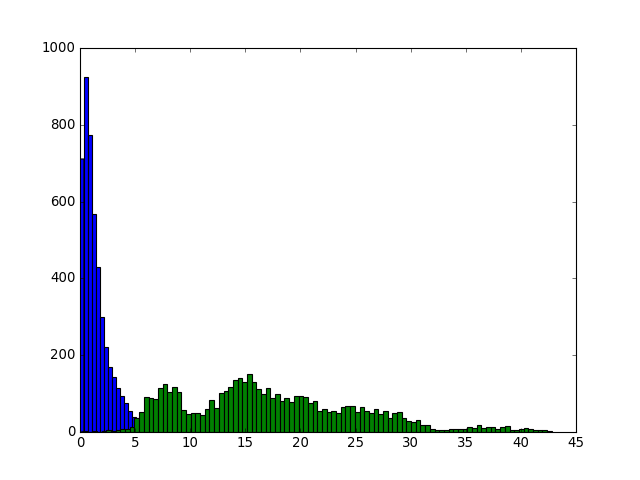

In [30]:
plt.figure()
out = plt.hist(get_random_pos_pairs(embs_by_class, 5000), bins=100)
out = plt.hist(get_random_neg_pairs(embs_by_class, 5000), bins=100)